# 1. Quick start: read csv and flatten json fields + smart dump

Hi! This notebook is a fork of https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields. It extends the original code by trimming useless features and efficient storage of the output for later usage

# Main goals
1. **Significantly reduce data readout time**
2. **Reduce memory footprint by some amount**
3. **Store flat datasets in an efficient format preserving data types**

Note, that storing flat datasets in csv will **not** preserve data types, and thus any type magic that we do here would be lost. Thus we will compare csv and a binary format (`parquete`). I would usually go with HDF5 format instead of parquete, but for some reason HDF5 files are **gigantic** for these data (factor 10 larger than csv and factor 100 larger than parquete)

The original function (from the aforementioned kernel) to flatten json features

In [1]:
# The number of entries to read in. Use it to have fast turn-around
max_events=None

import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import gc
gc.enable()
PATH = '/home/mlisovyi/.kaggle/competitions/google-analytics-customer-revenue-prediction/'

def load_df(csv_path=PATH+'train.csv', nrows=None, do_json=True):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    converters = {}
    if do_json:
        converters={'converters': {column: json.loads for column in JSON_COLUMNS}}
    
    df = pd.read_csv(csv_path,
                     **converters, 
                     dtype={'fullVisitorId': 'str', # Important!!
                            'date': 'str'
                           },
                     parse_dates=['date'],
                     nrows=nrows)
    
    if do_json:
        for column in JSON_COLUMNS:
            column_as_df = json_normalize(df[column])
            column_as_df.columns = ["{}.{}".format(column, subcolumn) for subcolumn in column_as_df.columns]
            df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
            gc.collect()
    print("Loaded {}. Shape: {}".format(os.path.basename(csv_path), df.shape))
    gc.collect()
    return df

print(os.listdir(PATH))

/home/mlisovyi/Drive/anaconda3/envs/pyviz/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


['train.csv', 'sample_submission.csv', 'test.csv']


/home/mlisovyi/Drive/anaconda3/envs/pyviz/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
import dask
import dask.dataframe as dd

In [3]:
# JSON_COLUMNS=['totals']
# df = dd.read_csv('../test_10k.csv', blocksize=1e6, 
#                  #converters={column: json.loads for column in JSON_COLUMNS},
#                  dtype={'fullVisitorId': 'str', # Important!!
#                             'date': 'str',
#                             'totals': 'str'
#                            },
#                      parse_dates=['date'],)

In [4]:
# df.head(1)

In [220]:
def_num = np.nan
def_str = 'NaN'

def get_keys_for_field(field=None):
    the_dict = {
        'device': [
            'browser', 'object',
            'deviceCategory',
            ('isMobile', False, bool),
            'operatingSystem'
        ],
        'geoNetwork': [
            'city',
            'continent',
            'country',
            'metro',
            'networkDomain',
            'region',
            'subContinent'
        ],
        'totals': [
            ('pageviews', def_num, np.int16),
            ('hits', def_num, np.int16),
            ('bounces', 0, np.int8),
            ('newVisits', 0, np.int16),
            ('totalTransactionRevenue', 0, np.float64),
            ('visits', -1, np.int16),
            ('timeOnSite', -1, np.int32),
            ('sessionQualityDim', -1, np.int8),
        ],
        'trafficSource': [
            'adContent',
            #'adwordsClickInfo',
            'campaign',
            ('isTrueDirect', False, bool),
            'keyword',
            'medium',
            'referralPath',
            'source'
        ],
    }
    return the_dict[field]


def convert_to_dict(x):
    #print(x, type(x))
    return eval(x.replace('false', 'False')
                .replace('true', 'True')
                .replace('null', 'np.nan'))

def develop_json_fields(df, json_fields=['totals'], cols_2drop=[]):
    df = df.drop(cols_2drop, axis=1)   
    # Get the keys
    for json_field in json_fields:
        print('Doing Field {}'.format(json_field))
        # Get json field keys to create columns
        the_keys = get_keys_for_field(json_field)
        # Replace the string by a dict
        print('Transform string to dict')        
        df[json_field] = df[json_field].apply(lambda x: convert_to_dict(x), meta=('','object'))
        
        print('{} converted to dict'.format(json_field))
        #display(df.head())
        for k in the_keys:
            if isinstance(k, str):
                t_ = def_str
                k_ = k
            else:
                t_ = k[1]
                k_ = k[0]
#             print(k)
            df[json_field + '_' + k_] = df[json_field].to_bag().pluck(k_, default=t_).to_dataframe().iloc[:,0]
#             print(df[json_field + '_' + k_].isnull().sum().compute())
            if not isinstance(k, str) and len(k)>2:
#                 print(k[2])
                df[json_field + '_' + k_] = df[json_field + '_' + k_].astype(k[2])
          
        del df[json_field]
        gc.collect()
        print('{} fields extracted'.format(json_field))
    return df

In [221]:
JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
df = dd.read_csv('../test_v2_clip.csv', blocksize=2e6, 
                 #converters={column: json.loads for column in JSON_COLUMNS},
                 dtype={'fullVisitorId': 'str', # Important!!
                            'date': 'str',
                            **{c: 'str' for c in JSON_COLUMNS}
                           },
                     parse_dates=['date'],)
df = df.partitions[:]

In [211]:
df.shape[0].compute()

10000

In [212]:
#dask.dataframe.core.Series

In [222]:
df2 = develop_json_fields(df, json_fields=['totals', 'device'], cols_2drop=['xxx1', 'hits'])

Doing Field totals
Transform string to dict
totals converted to dict
totals fields extracted
Doing Field device
Transform string to dict
device converted to dict
device fields extracted


In [223]:
df2.columns = ['{}_LAST'.format(c) for c in df2.columns]

In [233]:
df2.dtypes

channelGrouping_LAST                           object
date_LAST                              datetime64[ns]
fullVisitorId_LAST                             object
geoNetwork_LAST                                object
socialEngagementType_LAST                      object
trafficSource_LAST                             object
visitId_LAST                                    int64
visitNumber_LAST                                int64
visitStartTime_LAST                             int64
totals_pageviews_LAST                           int16
totals_hits_LAST                                int16
totals_bounces_LAST                              int8
totals_newVisits_LAST                           int16
totals_totalTransactionRevenue_LAST           float64
totals_visits_LAST                              int16
totals_timeOnSite_LAST                          int32
totals_sessionQualityDim_LAST                    int8
device_browser_LAST                            object
device_object_LAST          

In [227]:
pdf = df2.compute()

In [207]:
df2[df2['totals_hits']>1].compute().iloc[-1]

channelGrouping                                                              Direct
xxx1                                                                             []
date                                                            2018-09-07 00:00:00
fullVisitorId                                                   3875690118293601911
geoNetwork                        {"continent": "Asia", "subContinent": "Souther...
hits                              [{'hitNumber': '1', 'time': '0', 'hour': '7', ...
socialEngagementType                                           Not Socially Engaged
trafficSource                     {"referralPath": "(not set)", "campaign": "(no...
visitId                                                                  1536331301
visitNumber                                                                       1
visitStartTime                                                           1536331301
totals_pageviews                                                            

In [178]:
df2['hits'].head().iloc[0,]

"[{'hitNumber': '1', 'time': '0', 'hour': '12', 'minute': '10', 'isInteraction': True, 'isEntrance': True, 'isExit': True, 'page': {'pagePath': '/google+redesign/apparel/google+zip+hoodie+black', 'hostname': 'shop.googlemerchandisestore.com', 'pageTitle': 'Google Zip Hoodie Black', 'pagePathLevel1': '/google+redesign/', 'pagePathLevel2': '/apparel/', 'pagePathLevel3': '/google+zip+hoodie+black', 'pagePathLevel4': ''}, 'transaction': {'currencyCode': 'USD'}, 'item': {'currencyCode': 'USD'}, 'appInfo': {'screenName': 'shop.googlemerchandisestore.com/google+redesign/apparel/google+zip+hoodie+black', 'landingScreenName': 'shop.googlemerchandisestore.com/google+redesign/apparel/google+zip+hoodie+black', 'exitScreenName': 'shop.googlemerchandisestore.com/google+redesign/apparel/google+zip+hoodie+black', 'screenDepth': '0'}, 'exceptionInfo': {'isFatal': True}, 'product': [], 'promotion': [], 'eCommerceAction': {'action_type': '0', 'step': '1'}, 'experiment': [], 'customVariables': [], 'custom

In [174]:
df2.columns

Index(['channelGrouping', 'xxx1', 'date', 'fullVisitorId', 'geoNetwork',
       'hits', 'socialEngagementType', 'trafficSource', 'visitId',
       'visitNumber', 'visitStartTime', 'totals_pageviews', 'totals_hits',
       'totals_bounces', 'totals_newVisits', 'totals_totalTransactionRevenue',
       'totals_visits', 'totals_timeOnSite', 'totals_sessionQualityDim',
       'device_browser', 'device_object', 'device_deviceCategory',
       'device_isMobile', 'device_operatingSystem'],
      dtype='object')

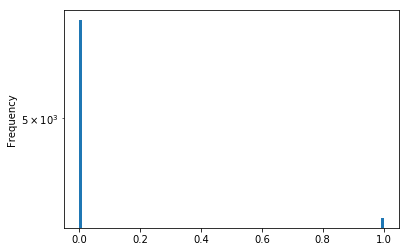

In [168]:
df2['totals_bounces'].fillna(-100).compute().plot('hist', logy=True, bins=10)

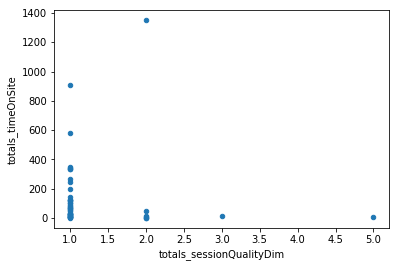

In [109]:
x= 'totals_sessionQualityDim'
y= 'totals_timeOnSite'
df2[[x,y]].astype(np.float16).compute().plot.scatter(x,y)

In [ ]:
pd.DataFrame.plot()

In [72]:
df2[df2['totals_bounces']!="1"].head()[['totals_bounces', 'hits']]

,totals_bounces,hits


In [212]:
#dask.dataframe.core.Series
#customDimensions hits

In [226]:
xx = develop_json_fields(df, json_fields=JSON_COLUMNS)

Doing Field device
Transform string to dict
device converted to dict
device fields extracted
Doing Field geoNetwork
Transform string to dict
geoNetwork converted to dict
geoNetwork fields extracted
Doing Field totals
Transform string to dict
totals converted to dict
totals fields extracted
Doing Field trafficSource
Transform string to dict
trafficSource converted to dict
trafficSource fields extracted


In [230]:
xx.info(verbose=True)

<class 'dask.dataframe.core.DataFrame'>
Int64Index: 9999 entries, 0 to 407
Data columns (total 34 columns):
channelGrouping                   9999 non-null object
date                              9999 non-null datetime64[ns]
fullVisitorId                     9999 non-null object
sessionId                         9999 non-null object
socialEngagementType              9999 non-null object
visitId                           9999 non-null int64
visitNumber                       9999 non-null int64
visitStartTime                    9999 non-null int64
device_browser                    9999 non-null object
device_object                     9999 non-null object
device_deviceCategory             9999 non-null object
device_isMobile                   9999 non-null bool
device_operatingSystem            9999 non-null object
geoNetwork_city                   9999 non-null object
geoNetwork_continent              9999 non-null object
geoNetwork_country                9999 non-null object
geoNetwor

In [207]:
xx.head(1)

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,trafficSource,visitId,visitNumber,visitStartTime,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_transactionRevenue,totals_visits
0,Organic Search,2017-10-16,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",6167871330617112363,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",6167871330617112363_1508151024,Not Socially Engaged,"{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508151024,2,1508151024,1,1,1,1,1,1


In [231]:
xx.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device_browser,device_object,...,totals_transactionRevenue,totals_visits,trafficSource_adContent,trafficSource_adwordsClickInfo,trafficSource_campaign,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source
0,Organic Search,2017-10-16,6167871330617112363,6167871330617112363_1508151024,Not Socially Engaged,1508151024,2,1508151024,Chrome,NaN,...,NaN,1,NaN,not available in demo dataset,(not set),True,(not provided),organic,NaN,google
1,Organic Search,2017-10-16,0643697640977915618,0643697640977915618_1508175522,Not Socially Engaged,1508175522,1,1508175522,Chrome,NaN,...,NaN,1,NaN,not available in demo dataset,(not set),False,(not provided),organic,NaN,google
2,Organic Search,2017-10-16,6059383810968229466,6059383810968229466_1508143220,Not Socially Engaged,1508143220,1,1508143220,Chrome,NaN,...,NaN,1,NaN,not available in demo dataset,(not set),False,(not provided),organic,NaN,google
3,Organic Search,2017-10-16,2376720078563423631,2376720078563423631_1508193530,Not Socially Engaged,1508193530,1,1508193530,Safari,NaN,...,NaN,1,NaN,not available in demo dataset,(not set),False,(not provided),organic,NaN,google
4,Organic Search,2017-10-16,2314544520795440038,2314544520795440038_1508217442,Not Socially Engaged,1508217442,1,1508217442,Safari,NaN,...,NaN,1,NaN,not available in demo dataset,(not set),False,(not provided),organic,NaN,google


In [115]:
type(df['totals'])

dask.dataframe.core.Series

In [117]:
dask.dataframe.core.Series.apply?

In [102]:
xx = develop_json_fields(df)

Doing Field totals
Transform string to dict
totals converted to dict
{'visits': '1', 'hits': '4', 'pageviews': '4'}


AttributeError: 'dict' object has no attribute 'replace'

## Let's load the original data with pre-processing

In [2]:
%%time
df_train = load_df(PATH+'/train.csv', nrows=max_events)
df_test = load_df(PATH+"/test.csv", nrows=max_events)

Loaded train.csv. Shape: (10000, 24)
Loaded test.csv. Shape: (10000, 24)
CPU times: user 2.6 s, sys: 151 ms, total: 2.76 s
Wall time: 3.56 s


In [3]:
def measure_memory(df, name):
    size_df = df.memory_usage(deep=True)
    print('{} size: {:.2f} MB'.format(name, size_df.sum()/ 1024**2))

In [4]:
measure_memory(df_train, 'Train')
measure_memory(df_test, 'Test')

Train size: 24.14 MB
Test size: 24.23 MB


In [5]:
gc.collect()

0

A short summary of observations: Reading in data is slow (~5:30 min) and the data take a lot of memory space (> 5 GB of RAM)

# How can we improve on that?
1. **Readout time can be reduced** if we __dump the flat dataset__ instead of runing json parsing every time(as is already implemented in the original kernel) and if we __drop irrelevant features__
2. **Memory footprint can be reduced** if we __drop irrelevant features__ and __optimise types__ assigned to features

# Drop irrelevant features
Since irrelevant features affect both reductions, let's start with it

See https://www.kaggle.com/c/google-analytics-customer-revenue-prediction/discussion/65691#387112 for sevral observations that led to the choice of features to be dropped

In [6]:
df_train.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.device,geoNetwork.geoNetwork,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,{'screenResolution': 'not available in demo da...,"{'longitude': 'not available in demo dataset',...",...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,{'screenResolution': 'not available in demo da...,"{'longitude': 'not available in demo dataset',...",...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,2016-09-02,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,{'screenResolution': 'not available in demo da...,"{'longitude': 'not available in demo dataset',...",...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,2016-09-02,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,{'screenResolution': 'not available in demo da...,"{'longitude': 'not available in demo dataset',...",...,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,2016-09-02,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,{'screenResolution': 'not available in demo da...,"{'longitude': 'not available in demo dataset',...",...,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


In [5]:
list_na = ['device.browserSize', 'device.browserVersion', 'device.flashVersion', 'device.language', 'device.mobileDeviceBranding', 'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName', 'device.mobileDeviceModel', 'device.mobileInputSelector', 'device.operatingSystemVersion', 'device.screenColors', 'device.screenResolution', 'geoNetwork.cityId', 'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.networkLocation', 'trafficSource.adwordsClickInfo.criteriaParameters']
list_single_value = ['trafficSource.campaignCode', 'socialEngagementType', 'totals.visits']

def drop_cols(df):
    df.drop(list_na, axis=1, inplace=True)
    df.drop([c for c in list_single_value if c in df.columns], axis=1, inplace=True)
    
for df in [df_test, df_train]:
    print(df.shape)
    drop_cols(df)    
    # drop sessionid, as it is a simple join of visitor and visit IDs
    df.drop('sessionId', axis=1, inplace=True)


(10000, 24)


ValueError: labels ['device.browserSize' 'device.browserVersion' 'device.flashVersion'
 'device.language' 'device.mobileDeviceBranding' 'device.mobileDeviceInfo'
 'device.mobileDeviceMarketingName' 'device.mobileDeviceModel'
 'device.mobileInputSelector' 'device.operatingSystemVersion'
 'device.screenColors' 'device.screenResolution' 'geoNetwork.cityId'
 'geoNetwork.latitude' 'geoNetwork.longitude' 'geoNetwork.networkLocation'] not contained in axis

## Deal with variables, that habe obvious missing value replacement schemes
Let's fill those variables that have been brought up in #5 of  https://www.kaggle.com/c/google-analytics-customer-revenue-prediction/discussion/65691#387112 plus a few extras

In [ ]:
for df in [df_train, df_test]:
    isAd = (df['channelGrouping'] == 'Paid Search')
    isRef = (df['channelGrouping'] == 'Social') | (df['channelGrouping'] == 'Referral')
    df.loc[isRef, 'trafficSource.referralPath'] = df.loc[isRef, 'trafficSource.referralPath'].astype('object').fillna('NaN').astype('category')
    df.loc[isAd, 'trafficSource.adwordsClickInfo.isVideoAd'] = (df.loc[isAd, 'trafficSource.adwordsClickInfo.isVideoAd'].fillna(True)).astype(bool)
    df.loc[isAd, 'trafficSource.adwordsClickInfo.page'] = df.loc[isAd,'trafficSource.adwordsClickInfo.page'].fillna(0).astype(np.uint8)
    df['trafficSource.isTrueDirect'] = (df['trafficSource.isTrueDirect'].fillna(False)).astype(bool)
    df['totals.bounces'] = (df['totals.bounces'].fillna(0)).astype(np.uint8)
    df['totals.newVisits'] = (df['totals.newVisits'].fillna(0).astype(np.uint8))
    df['totals.pageviews'] = (df['totals.pageviews'].fillna(0).astype(np.uint16))
    if 'totals.transactionRevenue' in df.columns:
        df['totals.transactionRevenue'] = df['totals.transactionRevenue'].fillna(0).astype(np.uint64)

## Reduce size of some variables
At the moment, `visitNumber` is float64, but it is an integer below 500

In [ ]:
for df in [df_train, df_test]:
    df['visitNumber'] = df['visitNumber'].astype(np.uint16)
    df['totals.hits'] = df['totals.hits'].astype(np.uint16)

# Store the pre-processed datasets

In [ ]:
gc.collect()
for name, df in zip(['train', 'test'],
                    [df_train, df_test]):
    #rename columns to get rid of the dot
    df.columns = [c.replace('.', '_') for c in df.columns]
    #df.to_csv("{}-flat.csv".format(name), index=False)
    #gc.collect()
    df.to_parquet(fname='{}-flat.pq'.format(name), compression=None, engine='pyarrow')
    del df
    gc.collect()

In [ ]:
!ls -l

In [ ]:
!ls -l

Note, that parquete files are 5 times smaller than csv

### Let's now test readout performance and RAM footprint
CSV

In [ ]:
# %%time 
# df_trn_c = load_df('train-flat.csv', nrows=max_events, do_json=False)
# df_tst_c = load_df('test-flat.csv' , nrows=max_events, do_json=False)

In [ ]:
# measure_memory(df_trn_c, 'Train')
# measure_memory(df_tst_c, 'Test')

Parquet

In [ ]:
%%time 
df_trn = pd.read_parquet('train-flat.pq')
df_tst = pd.read_parquet('test-flat.pq')

In [ ]:
measure_memory(df_trn, 'Train')
measure_memory(df_tst, 'Test')

Readout time and memory footprint are comparable after reading CSV and parquet files. I did not manage to make gzip-compressed parquet to work (in small tests it was smaller and readout was faster, but was very unstable and did not work at all for full dataset)

In [ ]:
#df_trn.memory_usage(deep=True) - df_trn_c.memory_usage(deep=True)

# Conclusions

- Readout time was reduced by more than an order of magnitude
- memory was reduced by factor 2

# What's next
Run this kernel and hook up the output of your fork as an input to your processing/EDA/training kernel. This way you will use this output **instead of the original coptetition dataset** and it will reduce the time lost on I/O.

P.S. Pipelining between kernels in kaggle is very useful

## Below are begugging tools

In [ ]:
# list_na = []
# for c in df_train.columns:
#     if 'not available in demo dataset' in df_train[c].unique():
#         list_na.append(c)

In [ ]:
# for c in list_na:
#     if df_train[c].unique().shape[0] == 1: 
#         print('{}: {}'.format(c, df_train[c].unique()))
#     else: 
#         print('{} contains, but not unique'.format(c))

In [ ]:
# list_nunique0 = []
# for c in df_train.columns:
#     if df_train[c].unique().shape[0] == 1 and c not in list_na:
#         list_nunique0.append(c)

In [ ]:
# for c in list_nunique0:
#     print(df_test[c].unique())